# DSCI 573 - Feature and Model Selection

# Lab 4: A mini project - Putting it all together

## Table of contents
0. [Submission instructions](#si) (4%)
1. [Understanding the problem](#1) (4%)
2. [Data splitting](#2) (2%)
3. [EDA](#3) (10%)
4. (Optional) [Feature engineering](#4)
5. [Preprocessing and transformations](#5) (10%)
6. [Baseline model](#6) (2%)
7. [Linear models](#7) (10%)
8. [Different models](#8) (16%)
9. (Optional) [Feature selection](#9)
10. [Hyperparameter optimization](#10) (10%)
11. [Interpretation and feature importances](#11) (10%)
12. [Results on the test set](#12) (10%)
13. [Summary of the results](#13) (12%)
15. (Optional) [Reproducible data analysis pipeline](#14)
15. (Optional) [Your takeaway from the course](#15)

## Submission instructions <a name="si"></a>
<hr>
rubric={mechanics:4}

You will receive marks for correctly submitting this assignment. To submit this assignment, follow the instructions below:

- **Which problem did you pick, classification or regression?**
- **Report your test score here along with the metric used:** 
- **Please add a link to your GitHub repository here: LINK TO YOUR  REPO**
- **You don't have to but you may work on this assignment in a group (group size <= 4) and submit your assignment as a group.** 
- Below are some instructions on working as a group.  
    - The maximum group size is 4. 
    - You can choose your own group members. Since I don't know your groups in advance, I am not opening this lab as a group lab. So you all will have a separate GitHub repository for your labs and you'll have to decide how you want to collaborate. 
    - Use group work as an opportunity to collaborate and learn new things from each other. 
    - Be respectful to each other and make sure you understand all the concepts in the assignment well. 
    - It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. [Here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members) are some instructions on adding group members in Gradescope.  
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).
- Make at least three commits in your lab's GitHub repository.
- Push the final .ipynb file with your solutions to your GitHub repository for this lab.
- Upload the .ipynb file to Gradescope.
- If the .ipynb file is too big or doesn't render on Gradescope for some reason, also upload a pdf or html in addition to the .ipynb. 
- Make sure that your plots/output are rendered properly in Gradescope.

> [Here](https://github.com/UBC-MDS/public/tree/master/rubric) you will find the description of each rubric used in MDS.

> As usual, do not push the data to the repository. 

## Imports

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import xgboost as xgb
import shap

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from scipy.stats import uniform, loguniform, randint

## Introduction <a name="in"></a>

In this lab you will be working on an open-ended mini-project, where you will put all the different things you have learned so far in 571 and 573 together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Pick your problem and explain what exactly you are trying to predict <a name="1"></a>
<hr>
rubric={reasoning:4}

In this mini project, you will pick one of the following problems: 

- A classification problem of predicting whether a credit card client will default or not. For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

OR 

- A regression problem of predicting `reviews_per_month`, as a proxy for the popularity of the listing with [New York City Airbnb listings from 2019 dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 
3. Carry out any preliminary preprocessing, if needed (e.g., changing feature names, handling of NaN values etc.)

1. 

We have picked the regression problem for this lab.  Overall, at a high level the problem is an interesting one.  The dataset is from 2019, and the prediction goal is to predict how many reviews per month an AirBnB listing in NY will get.  

It appears that there is a diverse set of features that will require different types of preproccessing.  For example there is a `name` feature that will likely require some NLP processing.  Further there are `latitude` and `longitude` features that will also require special pre-processing.  In addition there are a few features that appear irrelevant, such as listing ID and the name of the listing host.

In [2]:
airbnb_df = pd.read_csv("data/AB_NYC_2019.csv")

In [3]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [4]:
airbnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
airbnb_df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

- We noticed that there are ~10,000 columns with `NaN` values for our target label `reviews_per_month` and for the `last_review` feature.  Upon further inspection, this appears to be caused when a listing has a value for `number_of_reviews` that is equal to `0`.  In other words, when a listing has no reviews, then it has a `NaN` value in the `reviews_per_month` and `last_review` columns. In order to address this, we will fill these `NaN` values with `0`s, which better represents the values, which are not "missing" `NaN`s.
- Further, we noticed that there are 16 listings with missing values in `name`, and 21 listings with missing values in `host_name`.  As we have ~50k rows of data we will simply opt to drop the rows with the missing values in name and `host_name`, rather than trying to impute missing values.


In [6]:
airbnb_df["last_review"] = airbnb_df["last_review"].fillna(0)
airbnb_df["reviews_per_month"] = airbnb_df["reviews_per_month"].fillna(0)

airbnb_df = airbnb_df.dropna()

<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={reasoning:2}

**Your tasks:**

1. Split the data into train and test portions.

> Make decision on the `test_size` based on the capacity of your laptop. Don't forget to use a random state.  

In [7]:
train_df, test_df = train_test_split(airbnb_df, test_size=0.1, random_state=7)

<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={viz:4,reasoning:6}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

### Analysis of numeric features

In [8]:
# this removes id, host id, latitude, longitude
numeric = train_df.select_dtypes("number").columns.to_list()[4:]
round(train_df[numeric].describe().T, 1)

,count,mean,std,min,25%,50%,75%,max
price,43972.0,152.4,236.4,0.0,69.0,106.0,175.0,10000.0
minimum_nights,43972.0,7.0,19.6,1.0,1.0,2.0,5.0,1250.0
number_of_reviews,43972.0,23.3,44.7,0.0,1.0,5.0,24.0,629.0
reviews_per_month,43972.0,1.1,1.6,0.0,0.0,0.4,1.6,58.5
calculated_host_listings_count,43972.0,7.1,32.5,1.0,1.0,1.0,2.0,327.0
availability_365,43972.0,112.8,131.6,0.0,0.0,45.0,227.0,365.0


Above, we have calculated a summary of descriptive statistics for the numerical features in our data.  From the above we can see that:

- There appears to be some significant outliers in the `price` feature, as the max price is $10,000 which is several standard deviations away from the mean.
- There also appears to be significant outliers in the `minimum_nights` feature, as the max value for this feature is 1,250 which is also several standard deviations away from the mean.


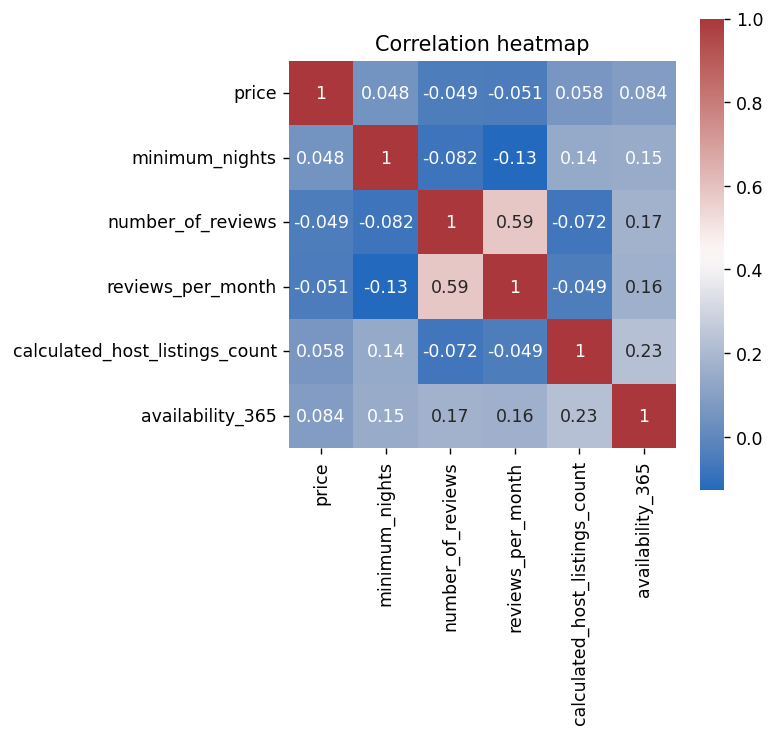

In [9]:
plt.figure(figsize=(5, 5), dpi=125)

sns.heatmap(
    train_df[numeric].corr(),
    cmap="vlag",
    annot=True,
    square=True
).set_title("Correlation heatmap");

In the above correlation heatmap we can see see that:
- For several of the numeric features, there is almost nil correlation between them.
- Our target feature `reviews_per_month` is highly correlated with `number_of_reviews` which makes sense, since users with an overall higher number of reviews would be expected to have a higher number of average reviews per month.

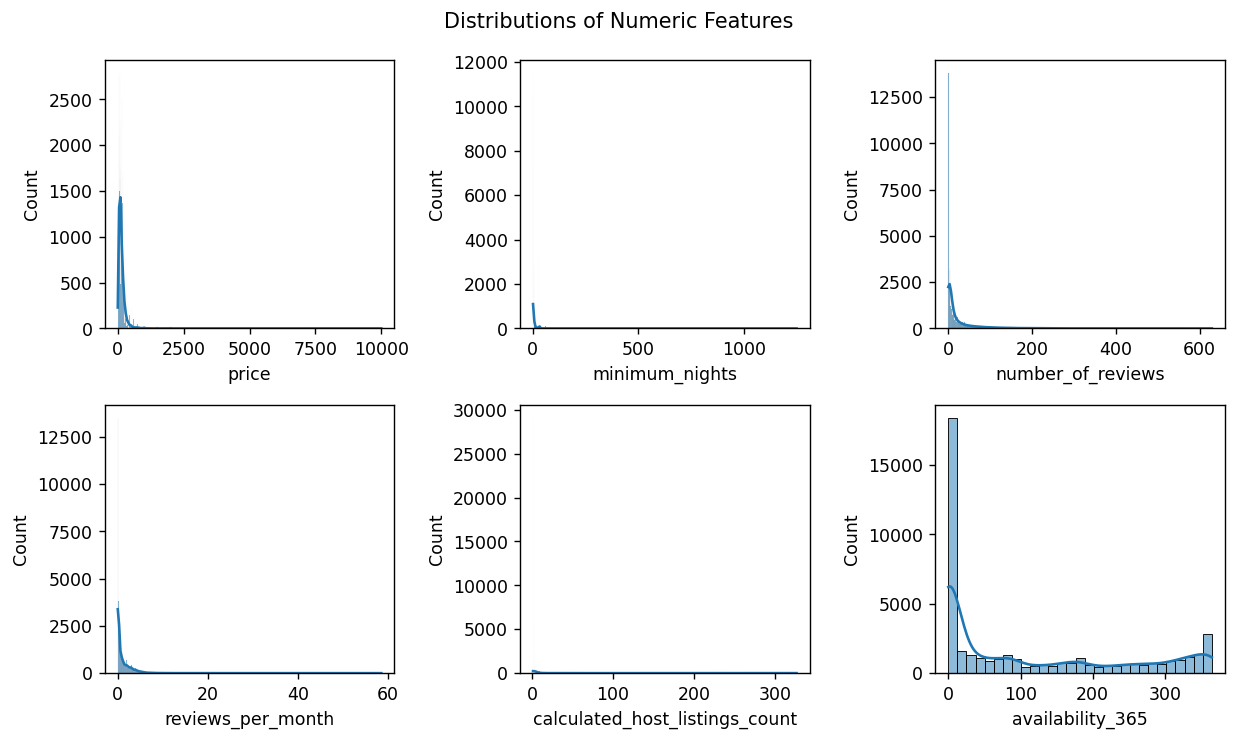

In [10]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 6), dpi=125)

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for feat, ax in zip(numeric, axes):
    sns.histplot(train_df, x=feat, kde=True, ax=ax)

plt.suptitle("Distributions of Numeric Features")
plt.tight_layout()

Based on the plot of the distributions of the numeric features we can see that except for the feature `availability_365`, the remaining features are all significantly skewed to the right.  We can consider how to fix this in feature engineering.

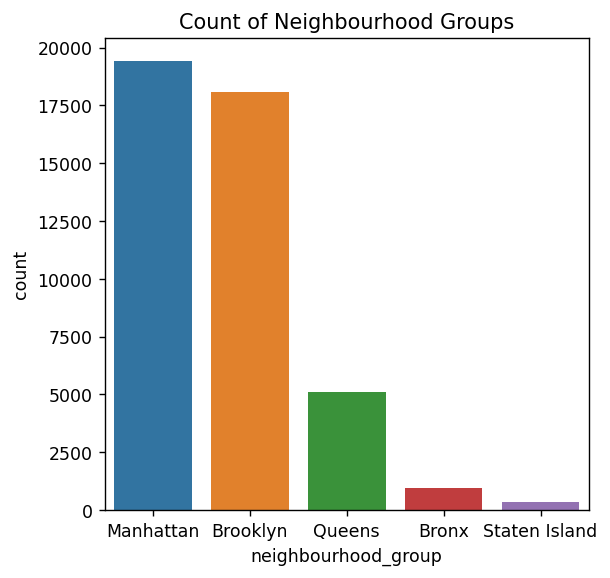

In [11]:
plt.figure(figsize=(5, 5), dpi=125)

sns.countplot(
    x="neighbourhood_group",
    data=train_df,
    order=train_df["neighbourhood_group"].value_counts().index
).set_title("Count of Neighbourhood Groups");

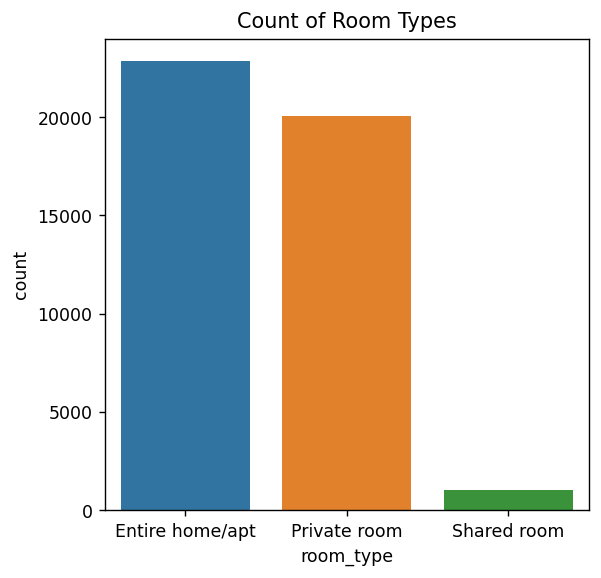

In [12]:
plt.figure(figsize=(5, 5), dpi=125)

sns.countplot(
    x="room_type",
    data=train_df,
    order=train_df["room_type"].value_counts().index
).set_title("Count of Room Types");

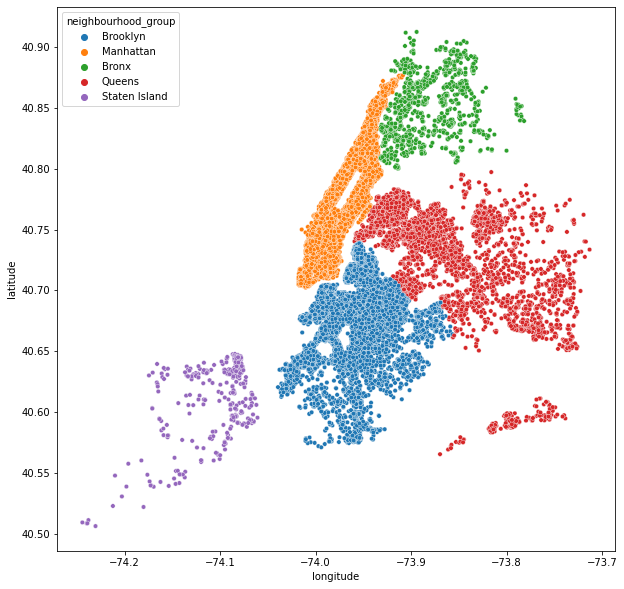

In [13]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='longitude', y='latitude', hue='neighbourhood_group',s=20, data=train_df);

The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


,neighbourhood_group,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Bronx,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089
1,Brooklyn,20089,20089,20089,20089,20089,20089,20089,20089,20089,20089,20089,20089,20089,20089,20089
2,Manhattan,21643,21643,21643,21643,21643,21643,21643,21643,21643,21643,21643,21643,21643,21643,21643
3,Queens,5664,5664,5664,5664,5664,5664,5664,5664,5664,5664,5664,5664,5664,5664,5664
4,Staten Island,373,373,373,373,373,373,373,373,373,373,373,373,373,373,373


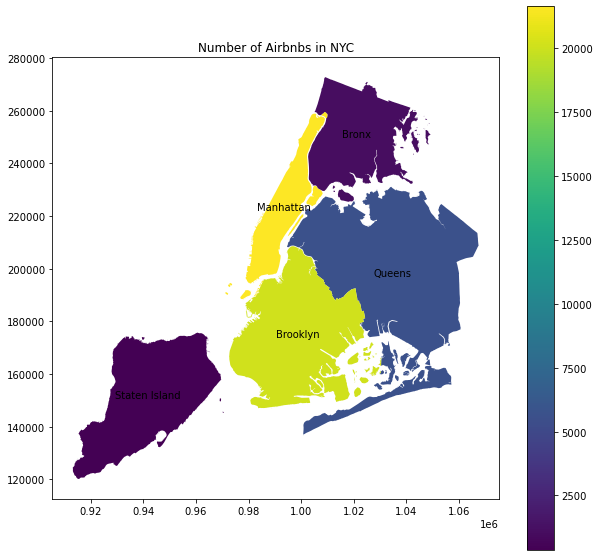

In [14]:
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))

borough_count = airbnb_df.groupby('neighbourhood_group').agg('count').reset_index()

nyc.rename(columns={'BoroName':'neighbourhood_group'}, inplace=True)
bc_geo = nyc.merge(borough_count, on='neighbourhood_group')

fig,ax = plt.subplots(1,1, figsize=(10,10))
bc_geo.plot(column='id', ax=ax, legend=True)
bc_geo.apply(lambda x: ax.annotate(s=x.neighbourhood_group, xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
plt.title("Number of Airbnbs in NYC")

borough_count

The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


Text(0.5, 1.0, 'Total reviews_per_month for each borough in NYC')

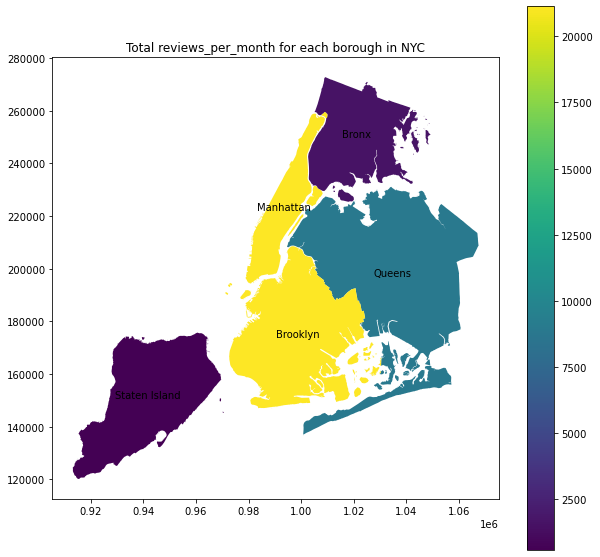

In [15]:
borough_sum = airbnb_df.groupby('neighbourhood_group').agg('sum').reset_index()

nyc.rename(columns={'BoroName':'neighbourhood_group'}, inplace=True)
bc_geo = nyc.merge(borough_sum, on='neighbourhood_group')

fig,ax = plt.subplots(1,1, figsize=(10,10))
bc_geo.plot(column='reviews_per_month', ax=ax, legend=True)
bc_geo.apply(lambda x: ax.annotate(s=x.neighbourhood_group, xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
plt.title("Total reviews_per_month for each borough in NYC")

<br><br>

We will use root mean squared error as the main metric to assess our model.  We will also calculate $R^2$ scores to asses how much of the variance our model is able to explain.

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

In [16]:
X_train = train_df.drop(columns=["reviews_per_month"])
y_train = train_df["reviews_per_month"]

X_test = test_df.drop(columns=["reviews_per_month"])
y_test = test_df["reviews_per_month"]

In [17]:
class CustomCatFeatures(BaseEstimator, TransformerMixin):
    """Custom sklearn transformer for feature engineering the airbnb dataset"""
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=1):
        
        X = X.copy()
        
        def transform_minimum_nights(x):
            """Bins minimum nights into categorical feature"""
            if 0 <= x <= 3:
                return "short_term_stay"
            elif 3 < x <= 7:
                return "medium_term_stay"
            else:
                return "long_term_stay"

        X["minimum_nights"] = X["minimum_nights"].apply(transform_minimum_nights)
        
        def transform_number_of_reviews(x):
            """Bins number_f_reviews into categorical feature"""
            if 0 <= x < 10:
                return "less_than_10_reviews"
            elif 10 < x <= 50:
                return "11_to_50_reviews"
            elif 50 < x <= 100:
                return "51_to_100_reviews"
            else:
                return "100+ reviews"
                
        X["number_of_reviews"] = X["number_of_reviews"].apply(transform_number_of_reviews)
        
        def transform_host_listings(x):
            """Bins host listings into categorical feature"""
            if x == 1:
                return "1_listing"
            else:
                return "2+_listings"
        
        X["calculated_host_listings_count"] = X["calculated_host_listings_count"].apply(transform_host_listings)
        
        return X

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [18]:
#TODO: Remove this, I did this now to save time in building the pipeline
X_train = X_train.iloc[:2500]
y_train = y_train.iloc[:2500]

X_test = X_test.iloc[:2500]
y_test = y_test.iloc[:2500]

In [19]:
drop_feat = [
    "id",
    "host_id",
    "host_name",
    "latitude",
    "longitude",
    "last_review",      # TODO: discuss, using now() creates issues
    "availability_365"  # TODO: discuss, could potentially engineer
]

cat_feat = [
    "neighbourhood_group",
    "neighbourhood",
    "room_type"
]

num_feat = [
    "price"
]

custom_cat_feats = [
    "minimum_nights",
    "number_of_reviews",
    "calculated_host_listings_count",

]

text_feat = "name"

assert set(drop_feat + cat_feat + num_feat + custom_cat_feats + [text_feat]) == set(X_train.columns)

In [20]:
custom_transformer = make_pipeline(
    CustomCatFeatures(),
    OneHotEncoder(handle_unknown="ignore", sparse=False)
)

preprocessor = make_column_transformer(
    ("drop", drop_feat),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_feat),
    (StandardScaler(), num_feat),
    (custom_transformer, custom_cat_feats),
#     (CountVectorizer(stop_words="english"), text_feat)
)

In [21]:
# TODO: consider deleting, in practice we wouldn't do this due to dimensionality
preprocessor.fit(X_train)

feat_names = (
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
    + num_feat
    + preprocessor.named_transformers_["pipeline"].named_steps["onehotencoder"].get_feature_names_out().tolist()
#     + preprocessor.named_transformers_["countvectorizer"].get_feature_names_out().tolist()
)

X_train.index

feat_names

X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train),
    index=X_train.index,
    columns=feat_names
)

X_train_enc.shape

(2500, 176)

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>
rubric={accuracy:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [22]:
dummy = DummyRegressor()

In [23]:
def get_mean_cv_scores(model, X_train, y_train, **kwargs):
    """Calculates and returns the mean cross validation score for a model.
    Parameters
    ----------
    model : sklearn estimator or xgb model
        The model to cross validate
    X_train : numpy ndarray
        The feature matrix
    y_train : numpy ndarray
        The target labels
    Returns
    -------
    pandas Series
        The mean cross validation scores with standard deviations
    """
    output = []

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()

    # present scores as score (+/- sd)
    for i in range(len(mean_scores)):
        output.append(f"{mean_scores[i]:.2f} (+/- {std_scores[i]:.2f})")

    return pd.Series(data=output, index=mean_scores.index)

In [24]:
results = {}

results["dummy"]  = get_mean_cv_scores(
    dummy, X_train, y_train, return_train_score=True, scoring="neg_mean_squared_error"
)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.00 (+/- 0.00),0.00 (+/- 0.00),-2.28 (+/- 0.20),-2.27 (+/- 0.05)


<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the regularization hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

In [25]:
ridge_pipe = make_pipeline(preprocessor, Ridge(random_state=7))

results["ridge"] = get_mean_cv_scores(
    ridge_pipe, X_train, y_train, return_train_score=True, scoring="neg_mean_squared_error"
)

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.00 (+/- 0.00),0.00 (+/- 0.00),-2.28 (+/- 0.20),-2.27 (+/- 0.05)
ridge,0.02 (+/- 0.00),0.01 (+/- 0.00),-1.31 (+/- 0.09),-1.14 (+/- 0.02)


In [26]:
ridge_cv_pipe = make_pipeline(preprocessor, RidgeCV())

results["ridge_tuned"] = get_mean_cv_scores(
    ridge_cv_pipe, X_train, y_train, return_train_score=True, scoring="neg_mean_squared_error"
)

pd.DataFrame(results).T

invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal
invalid value encountered in reciprocal


,fit_time,score_time,test_score,train_score
dummy,0.00 (+/- 0.00),0.00 (+/- 0.00),-2.28 (+/- 0.20),-2.27 (+/- 0.05)
ridge,0.02 (+/- 0.00),0.01 (+/- 0.00),-1.31 (+/- 0.09),-1.14 (+/- 0.02)
ridge_tuned,0.05 (+/- 0.01),0.01 (+/- 0.00),-1.29 (+/- 0.07),-1.20 (+/- 0.02)


<br><br>

## 8. Different models <a name="8"></a>
<hr>
rubric={accuracy:10,reasoning:6}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

In [27]:
models = {
    "RandomForest": RandomForestRegressor(),
    "SVR": SVR(),
    "XGB": xgb.XGBRegressor(verbosity=0)
}

In [28]:
for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    
    results[name] = get_mean_cv_scores(
        pipe, X_train, y_train, return_train_score=True, scoring="neg_mean_squared_error"
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.00 (+/- 0.00),0.00 (+/- 0.00),-2.28 (+/- 0.20),-2.27 (+/- 0.05)
ridge,0.02 (+/- 0.00),0.01 (+/- 0.00),-1.31 (+/- 0.09),-1.14 (+/- 0.02)
ridge_tuned,0.05 (+/- 0.01),0.01 (+/- 0.00),-1.29 (+/- 0.07),-1.20 (+/- 0.02)
RandomForest,1.10 (+/- 0.01),0.02 (+/- 0.00),-1.57 (+/- 0.14),-0.26 (+/- 0.01)
SVR,0.25 (+/- 0.01),0.11 (+/- 0.01),-1.38 (+/- 0.10),-1.19 (+/- 0.03)
XGB,0.25 (+/- 0.01),0.01 (+/- 0.00),-1.46 (+/- 0.11),-0.52 (+/- 0.02)


<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV`, forward selection or L1 regularization for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

In [29]:
#TODO: could consider DRY-ing this section out

In [30]:
pipes = {
#     "RandomForest": make_pipeline(preprocessor, RandomForestRegressor()),
    "SVR": make_pipeline(preprocessor, SVR()),
    "XGB": make_pipeline(preprocessor, xgb.XGBRegressor(verbosity=0))
}

In [31]:
rf_search_space = {
    "randomforestregressor__n_estimators": randint(100, 1000),
    "randomforestregressor__max_depth": np.arange(10, 100, 5),
    "randomforestregressor__max_features": ["auto", "log2"],
#     "columntransformer__countvectorizer__binary": [True, False],
#     "columntransformer__countvectorizer__max_features": randint(low=100, high=1600)
}

svr_search_space = {
    "svr__gamma": ["scale", "auto"],
    "svr__C": uniform(0.001, 1e4),
#     "columntransformer__countvectorizer__binary": [True, False],
#     "columntransformer__countvectorizer__max_features": randint(low=100, high=1600)
}

xgb_search_space = {
    "xgbregressor__n_estimators": randint(50, 500),
    "xgbregressor__max_depth": np.arange(5, 20),
    "xgbregressor__learning_rate": loguniform(0.3, 0.5),
#     "columntransformer__countvectorizer__binary": [True, False],
#     "columntransformer__countvectorizer__max_features": randint(low=100, high=1600)
}

search_spaces = [svr_search_space, xgb_search_space]

In [32]:
random_searches = {}

for name, pipe, search_space in zip(pipes.keys(), pipes.values(), search_spaces):
    random_search = RandomizedSearchCV(
        pipe,
        search_space,
        n_iter=25, #TODO: increase this at the end
        n_jobs=-1,
        random_state=7,
        scoring="neg_mean_squared_error"
    )
    
    random_searches[name + "_tuned"] = random_search.fit(X_train, y_train)

In [33]:
for name, search in random_searches.items():    
    results[name] = get_mean_cv_scores(
        search.best_estimator_, X_train, y_train, return_train_score=True, scoring="neg_mean_squared_error"
    )

pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.00 (+/- 0.00),0.00 (+/- 0.00),-2.28 (+/- 0.20),-2.27 (+/- 0.05)
ridge,0.02 (+/- 0.00),0.01 (+/- 0.00),-1.31 (+/- 0.09),-1.14 (+/- 0.02)
ridge_tuned,0.05 (+/- 0.01),0.01 (+/- 0.00),-1.29 (+/- 0.07),-1.20 (+/- 0.02)
RandomForest,1.10 (+/- 0.01),0.02 (+/- 0.00),-1.57 (+/- 0.14),-0.26 (+/- 0.01)
SVR,0.25 (+/- 0.01),0.11 (+/- 0.01),-1.38 (+/- 0.10),-1.19 (+/- 0.03)
XGB,0.25 (+/- 0.01),0.01 (+/- 0.00),-1.46 (+/- 0.11),-0.52 (+/- 0.02)
SVR_tuned,1.15 (+/- 0.10),0.15 (+/- 0.01),-1.40 (+/- 0.10),-1.08 (+/- 0.03)
XGB_tuned,0.22 (+/- 0.03),0.01 (+/- 0.00),-1.44 (+/- 0.12),-0.56 (+/- 0.02)


<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`), or any other methods of your choice, to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

In [34]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train),
    index=X_train.index,
    columns=feat_names
)

X_train_enc.shape

(2500, 176)

In [35]:
X_test_enc = pd.DataFrame(
    preprocessor.transform(X_test),
    index=X_test.index,
    columns=feat_names
)

X_train_enc.shape

(2500, 176)

In [36]:
pipe_xgb = random_searches["XGB_tuned"].best_estimator_

xgb_explainer = shap.TreeExplainer(pipe_xgb.named_steps["xgbregressor"])

train_xgb_shap_values = xgb_explainer.shap_values(X_train_enc)
test_xgb_shap_values = xgb_explainer.shap_values(X_test_enc)

In [37]:
train_xgb_shap_values.shape

(2500, 176)

In [38]:
test_xgb_shap_values.shape

(2500, 176)

In [39]:
shap.initjs()

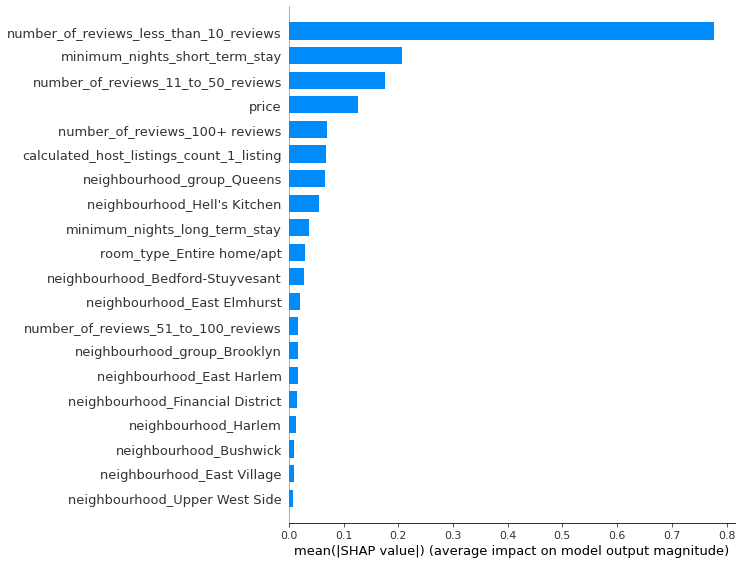

In [40]:
shap.summary_plot(train_xgb_shap_values, X_train_enc, plot_type="bar")

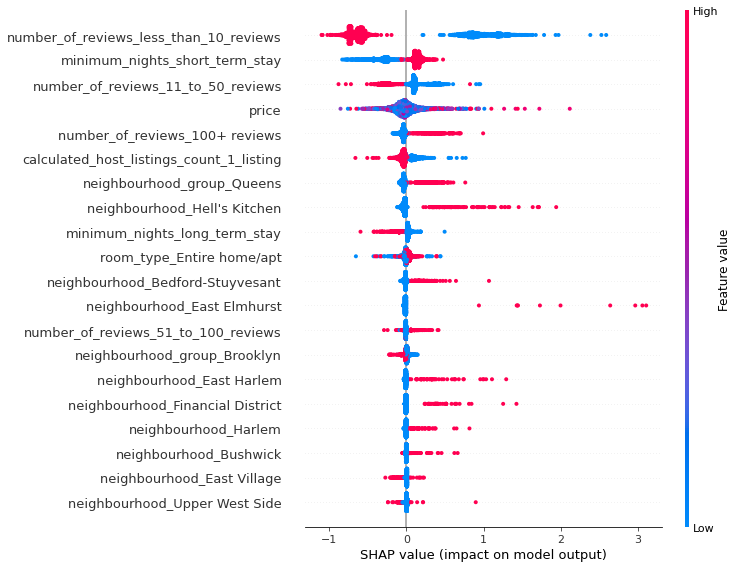

In [41]:
shap.summary_plot(train_xgb_shap_values, X_train_enc)

<br><br>

In [ ]:
#TODO: Explain shap plots

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain them with SHAP force plots.  

In [45]:
final_model = ridge_cv_pipe.fit(X_train, y_train)

invalid value encountered in reciprocal


In [49]:
y_pred = final_model.predict(X_test)

mean_squared_error(y_test, y_pred)

1.3594799158683188

In [ ]:
#TODO: Discuss results

In [52]:
#TODO: SHAP?  Our best model is regression...

<br><br>

## 13. Summary of results <a name="13"></a>
<hr>
rubric={reasoning:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

<br><br>

## (Optional) 14. Creating a data analysis pipeline <a name="14"></a>
rubric={reasoning:2}

**Your tasks:**
- In 522 you learned how build a reproducible data analysis pipeline. Convert this notebook into scripts and create a reproducible data analysis pipeline with appropriate documentation. 

<br><br>

## (Optional) 15. Your takeaway from the course <a name="15"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

What is your biggest takeaway from this course? 

For complex non-linear models, machine learning can be very hard to interpret/explain.

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Push all your work to your GitHub lab repository. 
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

Well done!! Have a great weekend! 

In [ ]:
from IPython.display import Image

Image("eva-well-done.png")